# Automatic differentiation in action

_Acknowledgements_: 
 * Credits to Mike Innes and Chris Rackauckas for their amazing work developing [`Zygote.jl`](https://fluxml.ai/Zygote.jl/latest/) and the entire [SciML ecosystem](https://sciml.ai), on which the code in this notebook is heavily built.
 * The code for fitting the parameters of a dynamic model with automatic differentiation is inspired by [an example from the SciMLSensitivity](https://sensitivity.sciml.ai/dev/ode_fitting/optimization_ode/) documentation. 
 * Huge thanks to Eva, Göran, Moritz, Martin, Anselm, Kiana and Harald for their valuable feedback on the notebook+workshop!

## Using Julia for Jupyter notebooks

_Instructions_:
  * download and install Julia: either the [current stable release v1.8](https://julialang.org/downloads/#current_stable_release) or v1.7.2, which I've installed in the Google Colab environment, available from the [older releases page](https://julialang.org/downloads/oldreleases/). 
  * open Julia (OS-dependent, but you should generally find a Julia icon somewhere in your programs or applications folder, on which you can double-click)
  * you should see the Julia REPL. Type in the following commands
    * `using Pkg` to use the package manager, 
    * `Pkg.add("IJulia")` to add the `IJulia` package needed to run Jupyter notebooks![](pictures/JuliaREPL.png) 
    * `using IJulia` to include the package
    * `installkernel("Julia")` to install the Julia kernel for Jupyter
    * `notebook()` to open a fresh Jupyter instance
  ![](pictures/JuliaREPL_notebook.png)
    * navigate to your local copy of the workshop repository in your file system and open the `Jupyter_Practicals.ipynb` file
  ![](pictures/Jupyter.png)

For more details on IJulia, see [the docs](https://julialang.github.io/IJulia.jl/stable/).

To install all all necessary Julia package dependencies as specified in the `Project.toml` file: 


In [ ]:
using Pkg;
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

Some packages need quite a while to precompile when importing them for the first time on a fresh runtime. Please run the following cell to precompile all packages needed in this notebook during the talk/demo/group discussion, to save some time later on 😃

In [ ]:
using Distributions
using Random
using Flux
using SciMLSensitivity
using OrdinaryDiffEq
using Plots 
using LaTeXStrings
using Zygote
gr()

# Autodiff in action: simple examples

Let's define some simple function and see if we use automatic differentiation to calculate the derivative.

First, we need to precompile `Zygote.jl`, Julia's main automatic differentiation library. 

In [ ]:
using Zygote # for taking gradients 

Just to get started, we'll calculate the "gradient" of the function $f(x) = x^2 + 4x - 1$ with respect to $x$, i.e., just the normal derivative: 
$f'(x) = 2x + 4$

In [ ]:
simple_function(x) = x^2 + 4x - 1

simple_function(2)
# 2^2 + 2*4 - 1

In [ ]:
gradient(simple_function, 3)
# f'(x) = 2x + 4

Of course, one doesn't need autodiff for that. Let's look at something more interesting: Julia's automatic differentiation system can naturally handle control flow, i.e., loops and recursion. We'll check that out by looking at two implementations of the power function $f(x,n) = x^n$, one involving a `for` loop, the other one involving recursion. 

In [ ]:
function power_loop(x,n)
    r = 1
    for i = 1:n
        r *= x 
    end
    return r 
end

function power_recursive(x,n)
    if n <= 0
        return 1 
    else
        return x * power_recursive(x, n-1)
    end
end

In [ ]:
x, n = 5, 3
power_loop(x, n)
power_recursive(x, n)

Let's take the gradients!

In [ ]:
gradient(x -> power_loop(x, n), 5)
gradient(x -> power_recursive(x, n), 5)

In [ ]:
# Automatic differentiation in action: fitting the parameters of an explicit dynamic model

Next, let's fit some parameters of a dynamic model. 

In [ ]:
using OrdinaryDiffEq
using Plots
using StatsBase
using SciMLSensitivity

Define a dynamical system based on a linear ordinary differential equation (ODE) system with an initial condition: 

\begin{align}
f'(u(t), t, A) &= A \cdot u(t); \\
u(t_0) &= u_0 
\end{align}

Here, we assume a simple 2-dimensional linear system, i.e., $u(t) \in \mathbb{R}^2$ and $A \in \mathbb{R}^{2\times 2}$:

\begin{align}
f'(u, A, t) &= \begin{pmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{pmatrix} \cdot \begin{pmatrix} u_1 \\ u_2 \end{pmatrix}(t); \\
u(t_0) &= u_0
\end{align}

In [ ]:
function linear_2d_system(du,u,p,t)
    a11, a12, a21, a22 = p
    z1,z2 = u
    du[1] = dz1 = a11 * z1 + a12 * z2
    du[2] = dz2 = a21 * z1 + a22 * z2
end

Define an ODE system based on this linear function, solve it and plot the solution: 

In [ ]:
tspan = (0.0f0, 1.0f0)
true_p = [-1.0, 0.0, 0.5, 1.0]
u0 = [2.0, 1.0]
dt = 0.1
prob = ODEProblem(linear_2d_system, u0, tspan, true_p, saveat=dt)
true_sol = solve(prob, Tsit5(), saveat=dt)
plot(true_sol.t, true_sol',
    label = ["true u_1" "true u_2"],
    legend = :topright,
    legendfontsize = 12,
    line=(3, ["#ff7f0e" "#1f77b4"])
)

Now, we take the solution based on these "true" parameters as our data, and see if we can recover the true parameters of our system. For this, we initialise the parameters randomly, and re-create our ODE problem with these parameters. The solution of this new problem will look different: 

In [ ]:
Random.seed!(42)
p = randn(4) # new random parameters
pred = solve(ODEProblem(linear_2d_system, u0, tspan, p, saveat=dt), Tsit5(), saveat=dt)
plot(true_sol.t, true_sol',
label = ["true u1" "true u2"],
legend = :topright,
legendfontsize = 12,
line=([:dot :dot], 3, ["#aec7e8" "#ffbb78"])
)
plot!(pred.t, pred'; 
line=(2, ["#1f77b4" "#ff7f0e"]),
label= ["predicted u1" "predicted u2"]
)    

We now want to see whether we can learn the true parameters of the system, by comparing the true solution -- our data -- against the prediction with our current parameters, and use gradient descent to minimise this error. We thus need to define a loss function: 
$\mathrm{loss}(\mathrm{data}, u_0, p) = \frac{1}{n} \sum_i^n \Vert \mathrm{data}_i - \mathrm{ODEsolve}(u_0, p)_i\Vert ^2$

and we try to find the minimum of this function w.r.t $p$, i.e., 
$\min_p \mathrm{loss}(\mathrm{data}, u_0, p)$, essentially by approximating 
$∇_p \mathrm{loss}(\mathrm{data}, u_0, p) = 0$. 

In [ ]:
function ODEloss(data, u0, p; dt=0.1)
    prob = ODEProblem(linear_2d_system, u0, tspan, p, saveat=dt)
    cur_sol = solve(prob, Tsit5(), saveat=dt)
    return mean((Array(cur_sol) .- data).^2)
end

In [ ]:
data = Array(true_sol)
ODEloss(data, u0, p)

Now we can optimise our model by using gradient descent on the loss function. For this, we need to obviously calculate the gradients first. This can be done just exactly as above for the simpler function, only that now our function involves an ODE-solving step! But the automatic differentiation framework of `Zygote.jl` can handle that "automatically". 

Let's look at our current values of the parameters vs. the true ones: 


In [ ]:
@info "current parameters: " p
@info "true parameters: " true_p

What signs should the values of the gradient for each parameter have? I.e., in which direction should they point? 

... think about this for a minute, then let's check it out: 

In [ ]:
    ∇loss = gradient(params -> ODEloss(data, u0, params), p)[1]

Now, we can update $p$ by gradient descent: 

In [ ]:
η = 0.01
p .-= η.*∇loss

And look at the loss again: 

In [ ]:
ODEloss(data, u0, p)

If we iterate that, we can fit the ODE parameters of our dynamic model to our data: 

In [ ]:
Random.seed!(42)
p = randn(4)
@info "initial loss is: $(round(ODEloss(data, u0, p), digits=3))"

η = 0.01
for step in 1:250
    ∇loss = gradient(params -> ODEloss(data, u0, params), p)[1]
    p .-= η.*∇loss
    pred = solve(ODEProblem(linear_2d_system, u0, tspan, p, saveat=dt), Tsit5(), saveat=dt)
    if step % 20 == 0
        @info "Current epoch: $step"
        @info "Current loss is:  $(round(ODEloss(data, u0, p), digits=3))"
        curplot=plot(true_sol.t, true_sol',
            label = ["true u1" "true u2"],
            legend = :topright,
            legendfontsize = 12,
            line=([:dot :dot], 3, ["#aec7e8" "#ffbb78"])
        )
        plot!(pred.t, pred'; 
            line=(2, ["#1f77b4" "#ff7f0e"]),
            label= ["fitted u1" "fitted u2"]
        )
        display(curplot)
    end
end

# Combining neural networks and differential equations to learn disease trajectories


---

>**Note** 
>
> * The following model + code is based on our [paper](https://doi.org/10.1002/bimj.202000366)  "*Deep dynamic modeling with just two time point - can we still allow for individual trajectories?*". 
> * The complete code + accompanying Jupyter notebooks can be found in [this repository](https://github.com/maren-ha/DeepDynamicModelingWithJust2TimePoints). 
> * I have developed the model in my master's thesis, where I describe it in much more detail. The thesis is publically available [here](https://github.com/maren-ha/MSc-Thesis).

---



## Introduction

Let's get back to the small data problem from the beginning: 

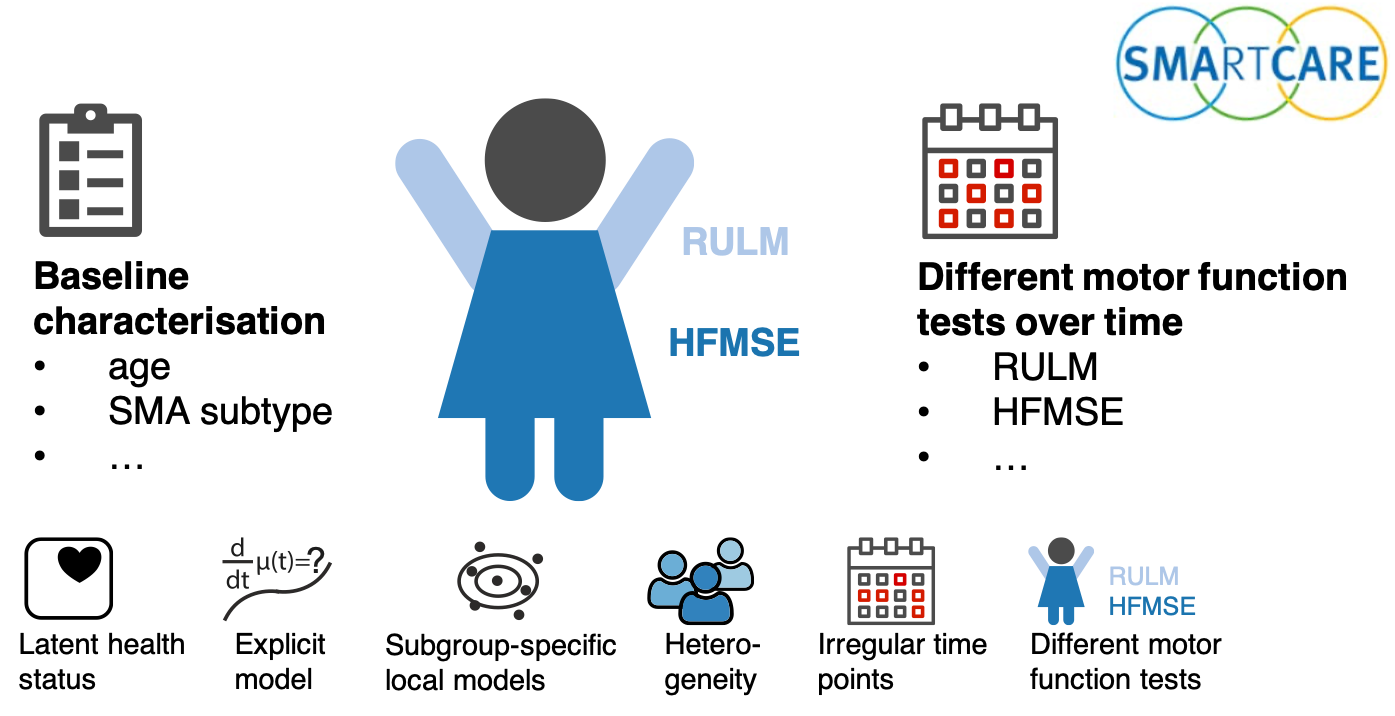

Let's focus on the first problem: inferring a latent health status from a large group of measured variables. This means we need a flexible dimension reduction, and we will use deep learning for that (as mentioned in yesterday evening's talk). 

Specifically, we wil use a variational autoencoder, a generative deep learning model. For a more in-depth introduction to VAEs, you can check out [this blogpost](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) or the [original paper](https://arxiv.org/abs/1312.6114) by Kingma and Welling. 

In brief, VAEs employ two independently parameterized but jointly optimized neural network models to learn an explicit parametrization of the underlying probability distributions of the dataset. This is achieved by non-linearly encoding the data into a lower-dimensional latent space and reconstructing back to the data space. Specifically, the encoder (or recognition model) maps the input data $x$ to a lower-dimensional representation given by the latent variable $z$, while the decoder network performs a reverse transformation and aims to reconstruct the input data based on the lower-dimensional latent representation. The model is trained essentially by comparing the input to the reconstructed output and trying to get them to match, such that the latent space recovers the central factors of variation that allow for approximating the data distribution.

The cool thing about *variational* autoencoders is that everything is formulated in terms of probability distributions, i.e., the model learns a latent space described by a random variable, and the encoder and decoder parameterise the conditional distributions of the latent variable given the data, $p_{\theta}(z|x)$ and the data given a sample from the latent space, $p_{\theta}(x|z)$, respectively. Since $p_{\theta}(z|x)$ is computationally  intractable, an approximation $q_{\phi}(z | x)$ is employed, called a *variational* approximation and typically given by a Gaussian distribution with diagonal covariance matrix. 

Formally, a training objective for the model can be derived based on [variational inference](https://arxiv.org/abs/1601.00670). The parameters $\phi$ and $\theta$ of the encoder and decoder distributions can be optimized by maximizing the evidence lower bound (ELBO), a lower bound for the true data likelihood $p_{\theta}(x)$. Denoting with $\mathrm{KL}$ the Kullback-Leibler divergence $\mathrm{KL}\left[ q \Vert p \right] := \mathbb{E}_{q}[\log \frac{q}{p}]$ for probability distributions $q$ and $p$, the ELBO is given by 

\begin{align}
ELBO(x; \phi, \theta) &= \mathbb{E}_{q_{\phi}(z|x)} \left[ \log \frac{p_{\theta}(x,z)}{q_{\phi}(z|x)} \right]\\
&= \mathbb{E}_{q_{\phi}(z|x)} \left[ \log p_{\theta}(x|z) \right] - \mathrm{KL} \left[ q_{\phi}(z|x) || p(x)\right]
\end{align}

The first term on the right side describes the reconstruction error indicating how well the generated samples from the model resemble the input. The KL-divergence on the right-hand side quantifies the difference between the approximate posterior to the true posterior, and, therefore, defines the tightness of the bound, i.e., the difference between the ELBO and the marginal likelihood. 

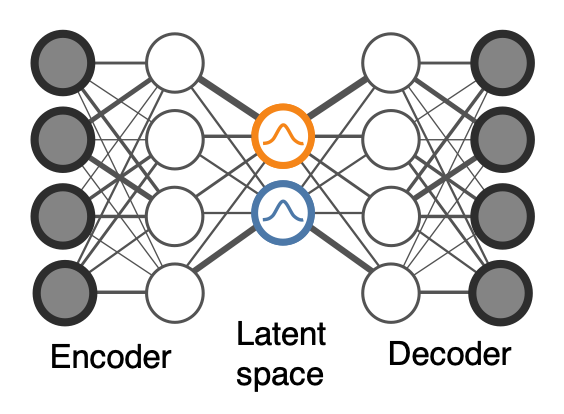

In our case, we will apply it to time-series data. Since I am not allowed to publically share the data from the SMArtCARE registry, let's simulate some data with a similar structure and use that for now (I will show a demo example for the SMArtCARE data later on). 

In [ ]:
using Distributions
using Random
using Flux
using OrdinaryDiffEq
using Plots 
using LaTeXStrings
gr()

## Simulate the data 

The ground-truth developments that we try to recover with our model are defined as solutions of linear 2-dimensional ODE systems. 

We first define the system and the two corresponding ODE problems with distinct parameters, corresponding to two distinct development patterns.

In [ ]:
# define true underlying ODE system
function linear_2d_system(du,u,p,t)
    a11, a12, a21, a22 = p
    z1,z2 = u
    du[1] = dz1 = a11 * z1 + a12 * z2
    du[2] = dz2 = a21 * z1 + a22 * z2
end
  
# define initial condition
true_u0 = Float32[2, 1]
# define time span on which to solve the ODE
tspan = (0.0f0, 10.0f0)
# define parameters for the two distinct groups
true_odeparams_group1 = Float32[-0.2, 0.00, 0.00, -0.2]
true_odeparams_group2 = Float32[-0.2, 0.00, 0.00, 0.2]
  
# define corresponding ODE problems for the two groups
prob1 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group1)
prob2 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group2)

Now, we can solve the ODE systems and look at the solutions for poth patterns. 

In [ ]:
# solve ODE systems to obtain "true" underlying trajectory in each group
dt=0.1
sol_group1 = solve(prob1, Tsit5(), saveat = dt);
sol_group2 = solve(prob2, Tsit5(), saveat = dt);
plot(sol_group1)

In [ ]:
plot(sol_group2)

Now, we simulate data of `n` individuals by adding noise to the true development patterns:

First, we randomly assign each individual into one of two groups, corresponding to the two distinct development patterns `sol_group1` and `sol_group2` created above. 

Next, for each simulated individual, we randomly draw a second measurement time point (or several subsequent random measurement time points) between `t_start`(default: 1.5) and `t_end` (default: 10) (here, `t_start`, `t_end`  $\in$ `tspan` is necessary). 

Then, for each individual, we simulate `p` measurements of each dimension of the ODE solution, i.e., for a 2-dimensional ODE system as in this example, we have $2*$ `p` variables. We do this by adding a variable-specific and an individual-specific measurement error to the true ODE solution of the individual's group at the individual-specific second measurement time point. These errors are drawn from to $\mathcal{N}(0,\sigma_{\mathrm{var}})$ and $\mathcal{N}(0,\sigma_{\mathrm{ind}})$, respectively.

In [ ]:
"""
    generate_xs(n, p, true_u0, sol_group1, sol_group2; t_start=1.5, t_end=10, maxntps = 10, dt=0.1, σ_var=0.1, σ_ind=0.5)

Generates simulated data by sampling `n` observations of `p` variables at between 1 and `maxntps` timepoints for each individual 
    by randomly selecting one of the true underlying ODE solutions given by `sol_group1` and `sol_group2`, taking its values 
    at a randomly sampled number between 1 and `maxntps` of randomly sampled time points and adding variable-specific 
    and individual-specific errors to the values of the true trajectories, where the variance of the error terms is controlled by 
    `σ_var` and `σ_ind`. 

Inputs: 
  - `n`: number of individuals to simulate 
  - `p`: number of time-dependent variables to simulate - should be divisible by the number of the true underlying 
        trajectory dimensions, so the first (p/n_true_dimensions) variables can be noisy versions of the first dimension of 
        the true dynamics, and so on. 
  - `true_u0`: vector stating the initial condition of the ground-truth underlying ODE systems from which to simulate the data 
  - `sol_group1`: true ODE solution of the first group 
  - `sol_group2`: true ODE solution of the second group 

Optional keyword arguments: 
 - `t_start`: Earliest time point possible for follow-up measurements, start of the interval from which to sample the 
        subsequent measurement time point(s). Default = 1.5
 - `t_end`: Latest time point possible for follow-up measurements, end of the interval from which to sample the 
        subsequent measurement time point(s). Default = 10
 - `maxntps`: maximum number of time points per individual after the baseline timepoint. Default = 1
 - `dt`: time steps at which to solve the ODE. Needed to ensure correct array sizes. Default = 0.1
 - `σ_var`: variance with which to sample the variable-specific error terms. Default = 0.1
 - `σ_ind`: variance with which to sample the individual-specific error terms. Default = 0.5

Returns:
 - `xs`: vector of length `n` = n_individuals, where the `i`th element is a (n_vars=p x n_timepoints) matrix 
        containing the simulated values of the time-dependent variables of the `i`th individual in the dataset
 - `tvals`: vector of length `n` = n_individuals, where the `i`th element is a vector of length 1 (or more generally n_timepoints_i)
        containing the simulated time point of the `i`th individual's second measurement (or all the timepoints after the baseline visit)
 - `group1`: indices of all individuals in group1 
 - `group2`: indices of all individuals in group1 
"""
function generate_xs(n, p, true_u0, sol_group1, sol_group2; t_start=1.5, t_end=10, maxntps = 10, dt=0.1, σ_var=0.1, σ_ind=0.5)

    # (1) generate artifical group labels
    groups = zeros(n)
    groups[randperm(n)[1:Int(floor(n/2))]] .= 1 # for groups of the same size
    group1 = findall(x -> x==1, groups)
    group2 = findall(x -> x==0, groups)

    # (2) generate artificial time stamps
    ntps = rand(1:maxntps, n)
    tvals = [sort(rand(t_start:dt:t_end,ntps[i])) for i in 1:n]

    # (3) obtain true values as solutions of the ODEs at the initial time point and the drawn second time point 
    # check for equal number of variables:
    if p%2 != 0
        error("Please select an even number of variables")
    end
    # true starting point    
    z_t0_p1 = true_u0[1] # for variables 1-(p/2)
    z_t0_p2 = true_u0[2] # for variables (p/2+1)-p
    z_t0 = repeat([z_t0_p1, z_t0_p2], inner=Int(p/2))

    # now use ODE solutions to obtain true temporal development value
    # for all individuals in both variables u1 and u2
    z_later_ts = collect((i ∈ group1) ? (Array(sol_group1)[:,Int.(round.(tvals[i].*(1 ./dt)).+1)]) : (Array(sol_group2)[:,Int.(round.(tvals[i].*(1 ./dt)).+1)]) for i in 1:n)

    # (4) sample variable- specific and individual-specific errors at both time points
    # variable specific random effect (general difficulty measuring that specific variable)
    us = rand(Normal(0,σ_var),p) 

    xs = []
    for i in 1:n 
        # make time series structure, should have shape (p x ntps[i])
        cur_timeseries = zeros(p, ntps[i]+1)
        for j in 1:p 
            cur_timeseries[j,1] = z_t0[j] + us[j] + randn() .* σ_ind
            for tp in 1:ntps[i]
                if j <= Int(p/2)
                    cur_timeseries[j,tp+1] = z_later_ts[i][1,tp] + us[j] + randn() .* σ_ind
                else
                    cur_timeseries[j,tp+1] = z_later_ts[i][2,tp] + us[j] + randn() .* σ_ind
                end
            end
        end
        push!(xs, cur_timeseries)
    end

    return xs, tvals, group1, group2
end

In [ ]:
# define numbers of individuals and variables 
n = 100 
p = 10
q, q_info = 50, 10

# set seed for reproducibility
Random.seed!(12);

# generate time dependent variables
xs, tvals, group1, group2 = generate_xs(n, p, true_u0, sol_group1, sol_group2); 
# default vals: t_start=1.5, t_end=10, maxntps=10, dt=0.1, σ_var=0.1, σ_ind=0.5

Finally, we generate the corresponding baseline variables that reflect the more extensive characterization of the individuals at the baseline time point $t_0$. Here, we distinguish between two possibilites of either drawing from the true ODE parameters with some added random noise, or drawing from the group membership information encoded as $\pm 1$ with random noise. In both scenarios, we simulate `q_info` variable with that noisy information about either the ODE parameters or the group membership, and simulate additional variables that contain purely random noise, until we end up with a total of `q` baseline variables.  

In [ ]:
"""
    generate_baseline(n, q, q_info, group1; σ_info=1, σ_noise=1)

Generates simulated baseline data by sampling `n` observations of `q` baseline variables, of which only the first `q_info`
    are informative, and the other ones are just pure noise variables, based on the group membership information. 
    This information is given by `group1`, the indices of all individuals in group1, based on which the other indices in 
    group 2 can be inferred, since union(group1, group2) = {1,...,n}. 
    Baseline measurements are simulated by encoding group membership as 1 or -1 and drawing from N(0,σ_info) or N(1, σ_info),
    repectively. For the noise variables, data are simulated by drawing from N(0, σ_noise). 

Inputs: 
 - `n`: number of individuals to simulate 
 - `q`: number of baseline variables to simulate 
 - `q_info`: number of informative baseline variables. 
 - `group1`: indices of all individuals in group1 - since [group1, group2] = {1,...,n}, the `group2` indices can be inferred from that

Optional keyword arguments: 
 - `σ_info`: variance with which to sample from the group membership information in the informative baseline variables terms. Default = 1
 - `σ_noise`: variance with which to sample the noise baseline variables terms. Default = 1

Returns:
 - `x_params`: vector of length `n` = n_individuals, where the `i`th  element is a vector of length (n_baselinevars=q)
        containing the baseline information for the `i`th individual in the dataset 
"""
function generate_baseline(n, q, q_info, group1; σ_info=1, σ_noise=1)
    zs = fill(1,(n,1))
    zs[group1].= -1
    means = fill(0,n,q)
    means[:,1:q_info] .= zs

    vars=fill(σ_noise,q)
    vars[1:q_info] .= σ_info
    x_params = [cat([rand(Normal(means[i,j],vars[j])) for j in 1:q]..., dims=1) for i in 1:n]
    return x_params
end

"""
    generate_baseline(n, q, q_info, group1, true_odeparams_group1, true_odeparams_group2; σ_info=0.1, σ_noise=0.1)

Generates simulated baseline data by sampling `n` observations of `q` baseline variables, of which only the first `q_info`
    are informative, and the other ones are just pure noise variables, based on the true ODE parameters passed as 
    `true_odeparams_group1` and `true_odeparams_group2`. 
    Baseline measurements are simulated by sampling from the true parameters with a standard deviation of σ_info. 
    For the noise variables, data are simulated by drawing from N(0, σ_noise). 

Inputs: 
 - `n`: number of individuals to simulate 
 - `q`: number of baseline variables to simulate 
 - `q_info`: number of informative baseline variables. 
 - `group1`: indices of all individuals in group1 - since [group1, group2] = {1,...,n}, the `group2` indices can be inferred from that

Optional keyword arguments: 
 - `σ_info`: variance with which to sample from the group membership information in the informative baseline variables terms. Default = 0.1. 
 - `σ_noise`: variance with which to sample the noise baseline variables terms. Default = 0.1. 

Returns:
 - `x_params`: vector of length `n` = n_individuals, where the `i`th  element is a vector of length (n_baselinevars=q)
        containing the baseline information for the `i`th individual in the dataset 
"""
function generate_baseline(n, q, q_info, group1, true_odeparams_group1, true_odeparams_group2; σ_info=0.1, σ_noise=0.1)
    signs = fill(1,(n,1))
    signs[group1] .= -1
    z1s = zeros(n,1)
    z1s[signs .== -1] .= true_odeparams_group1[1]
    z1s[signs .== 1] .= true_odeparams_group2[1]
    z2s = zeros(n,1)
    z2s[signs .== -1] .= true_odeparams_group1[4]
    z2s[signs .== 1] .= true_odeparams_group2[4]

    means = zeros(n,q)
    means[:,1:Int(floor(q_info/2))] .= z1s
    means[:,Int(floor(q_info/2))+1:q_info] .=z2s

    vars=fill(σ_noise,q)
    vars[1:q_info] .= σ_info
    x_params = [cat([rand(Normal(means[i,j],vars[j])) for j in 1:q]..., dims=1) for i in 1:n]
    return x_params
end

In [ ]:
# choose simulation setting for baseline variables 
baseline_simulation = "trueparams" # alternative: "groupsonly"

# generate baseline variables
if baseline_simulation == "trueparams"
    x_baseline = generate_baseline(n, q, q_info, group1, 
                                    true_odeparams_group1, true_odeparams_group2, 
                                    σ_info=0.1, σ_noise=0.1); 
    # defaul vals: σ_info=0.1, σ_noise=0.1
elseif baseline_simulation == "groupsonly"
    x_baseline = generate_baseline(n, q, q_info, group1, σ_info=1, σ_noise=1); 
    # default vals: σ_info=1, σ_noise=1
else
    error("Please select either 'trueparams' or 'groupsonly' as mode for simulation of baseline variables")
end
@info "simulation done!"

Let's have a look at the data we generated (showing only the true ODE solutions as lines and the first row and the solutions and drawn measurements as dots in the second row), separately for each group (=column).

Again, we first define some functions for convenient plotting, to visualise the data and the learned trajectories.

In [ ]:
#------------------------------
# some plotting functions for simulated data
#------------------------------

struct simdata
    xs
    x_baseline
    tvals
    group1
    group2
end

"""
    plot_truesolution(group, data::simdata, sol_group1, sol_group2; showdata=true)

Plots the true dynamics of one group according to the underlying ODE solution and the simulated data points on top. 

Inputs: 
 - `group`: integer specifying which group (1 or 2) to plot 
 - `data`: container of type `simdata` with all the simulated data (time-dependent and baseline variables, time points)
 - `sol_group1`: true ODE solution of the first group 
 - `sol_group2`: true ODE solution of the second group 

Returns: 
    a plot showing the true underlying ODE solutions as curves and the simulated time-dependent observations 
    as points on top. The two underlying dimensions of the ODE / the corresponding simulated variables 
    are color-coded in orange and blue. 
"""
function plot_truesolution(group, data::simdata, sol_group1, sol_group2; showdata=true)
    if group == 1
        sol = sol_group1
        groupinds = data.group1
        legendposition = :topright
    else
        sol = sol_group2
        groupinds = data.group2
        legendposition = :topleft
    end
    curplot = plot(sol.t, sol',
                label = [L"\mathrm{true~solution~}u_1" L"\mathrm{true~solution~}u_2"],
                legend = legendposition,
                legendfontsize = 12,
                line=(3, ["#ff7f0e" "#1f77b4"])
                )
    if !showdata
        return curplot
    else
        for ind in 1:length(data.xs[groupinds])
            for var in 1:size(data.xs[groupinds][1],1)
                color = "#ffbb78" 
                if var > 5
                    color = "#aec7e8"
                end
                Plots.scatter!(cat(0,data.tvals[groupinds][ind], dims=1), data.xs[groupinds][ind][var,:], label="", marker=(:c,6,color))
            end
        end
    end
    return curplot
end

In [ ]:
# look at data: 
data = simdata(xs, x_baseline, tvals, group1, group2);

plot(plot_truesolution(2, data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(2, data, sol_group1, sol_group2, showdata=true), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=true),
    layout = (2,2),
    legend = false,
    size = (900,600)
)

In [ ]:
## Define and train a VAE

Let's start by training a simple VAE on the data, to address our first challenge of identifying a latent health status (=the latent space of our VAE). In the second step, we will then add in the differential equation. 

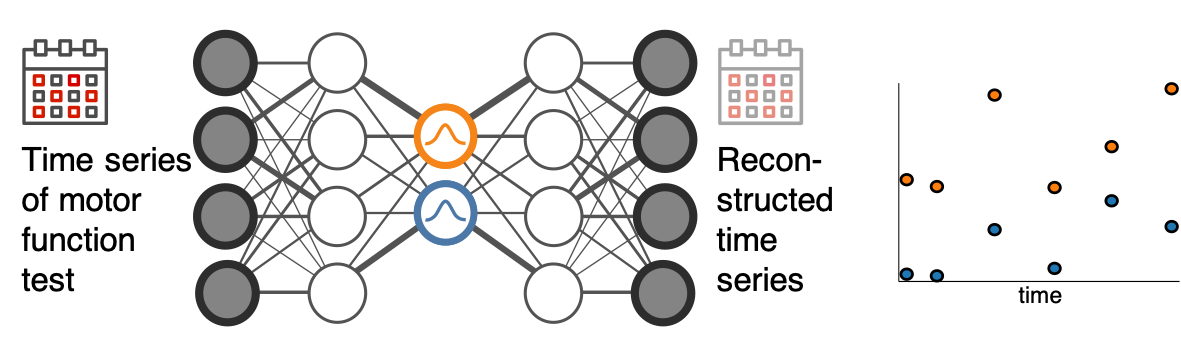

First, we define a `struct`, i.e., a sort of custom type, for our VAE model, and write a function how to construct, i.e., initialise the model. 

In [ ]:
mutable struct VAE 
    encoder
    encodedμ 
    encodedlogσ 
    decoder
    decodedμ 
    decodedlogσ 
end

function VAE(p::Int, zdim::Int; seed::Int=1234)
    Random.seed!(seed) # random weight initialisation - set seed for reproducibility
    #   VAE encoder
    Dz, Dh = zdim, p
    encoder, encodedμ, encodedlogσ = Dense(p, Dh, arg ->(tanh.(arg) .+ 1)), Dense(Dh, Dz), Chain(Dense(Dh, Dz, arg -> -relu(arg)), Flux.Diagonal(Dz))
    # VAE decoder
    decoder, decodedμ, decodedlogσ = Dense(Dz, Dh, tanh), Dense(Dh, p), Dense(Dh, p)
    return VAE(encoder, encodedμ, encodedlogσ, decoder, decodedμ, decodedlogσ)
end

Next, we define a loss function for the model: essentially the negative ELBO that we've seen before: 

In [ ]:
latentz(μ, logσ) = μ .+ sqrt.(exp.(logσ)) .* randn(Float32,size(μ)...) # sample latent z,

kl_q_p(μ, logσ) = 0.5 .* sum(exp.(logσ) + μ.^2 .- 1 .- (logσ),dims=1)

logp_x_z(m, x, z) = sum(logpdf.(Normal.(m.decodedμ(m.decoder(z)), sqrt.(exp.(m.decodedlogσ(m.decoder(z))))), x),dims=1) # get reconstruction error

sqnorm(x) = sum(abs2, x)

reg(m) = sum(sqnorm, Flux.params(m.decoder,m.decodedμ,m.decodedlogσ)) # regularisation term in loss

getparams(m::VAE) = Flux.params(m.encoder, m.encodedμ, m.encodedlogσ, m.decoder, m.decodedμ, m.decodedlogσ) # get parameters of VAE model

function loss(m::VAE, X)
    latentμ, latentlogσ = m.encodedμ(m.encoder(X)), m.encodedlogσ(m.encoder(X))
    Z = latentz.(latentμ, latentlogσ)
    ELBO = 1.0 .* logp_x_z(m, X, Z) .- 0.5 .* kl_q_p(latentμ, latentlogσ)
    lossval = sum(-ELBO) + 0.01*reg(m) 
    return lossval
end

To look at our model latent space during training, we define another plotting function: 

In [ ]:
function eval_zs(xs, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false) # look at trajectories of 4 exemplary individuals during training
    plotarray=[]
    for ind in 2:5
        curgroup = ind ∈ group1 ? 1 : 2
        colors_truesol = swapcolorcoding ? ["#ff7f0e" "#1f77b4"] : ["#1f77b4" "#ff7f0e"]
        curxs = xs[ind]
        curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
        curz = latentz.(curmu, cursi)
        curts = tvals[ind] .* (1 ./dt) .+ 1
        #origt1s = repeat([tvals[ind]], length(curxs[:,1]))
        #origxst0 = curxs[:,1]
        #origxsotherts = curxs[:,2:end]
        curplot = curgroup == 1 ? plot(sol_group1.t, sol_group1'; legend=false, line=([:dot :dot], 3, colors_truesol)) : plot(sol_group2.t, sol_group2'; legend=false, line=([:dot :dot], 3, colors_truesol))
        Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[1,:], marker = (:c, 4, "#1f77b4")) 
        Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[2,:], marker = (:c, 4, "#ff7f0e"))
        # Plots.scatter!(zeros(10,1), origxst0; marker=(:c, 3, "#bab0ac"), alpha=0.5)
        #for tp in 1:length(tvals[ind])
        #    Plots.scatter!(repeat([tvals[ind][tp]], length(curxs[:,1])), origxsotherts[:,tp]; marker=(:c, 3, "#bab0ac"), alpha=0.5)
        #end
        push!(plotarray, curplot)
    end
    myplot = plot(plotarray[:]..., layout=(2,2))
    return myplot
end

Now, we can initialise our model...

In [ ]:
zdim = 2
m = VAE(p, zdim, seed=678)

... and check out its current loss and current latent space: 

In [ ]:
display(eval_zs(xs, group1, sol_group1, sol_group2, m, dt))
@info "mean loss: $(mean(loss(m, X) for X in xs))"

Wow, that's messy - let's try to improve that by training the model. 

We specify our model parameters (=the parameters for which we want to calculate the gradients later on) and the optimiser, just as for the small ODE example before. 

In [ ]:
ps = getparams(m)
opt = ADAM(0.0005)

... and finally start training! 

In [ ]:
for epoch in 1:25
    for X in xs 
        grads = Flux.gradient(()-> loss(m, X), ps)
        Flux.Optimise.update!(opt, ps, grads)
    end
    if epoch % 5 == 0
        @info "mean loss: $(mean(loss(m, X) for X in xs))"
        display(eval_zs(xs, group1, sol_group1, sol_group2, m, dt; swapcolorcoding=true))
    end
end

## Define and train an ODE-VAE

Ok, that doesn't look too bad! Let's see if we can further improve that and get an explicit description of the dynamics in the latent space by adding in the ODE part. 

Also, we haven't even used our baseline variables. Let's see if we can add them to get individual-specific parameters of our latent dynamic system. 

Our complete model will then look like this: 

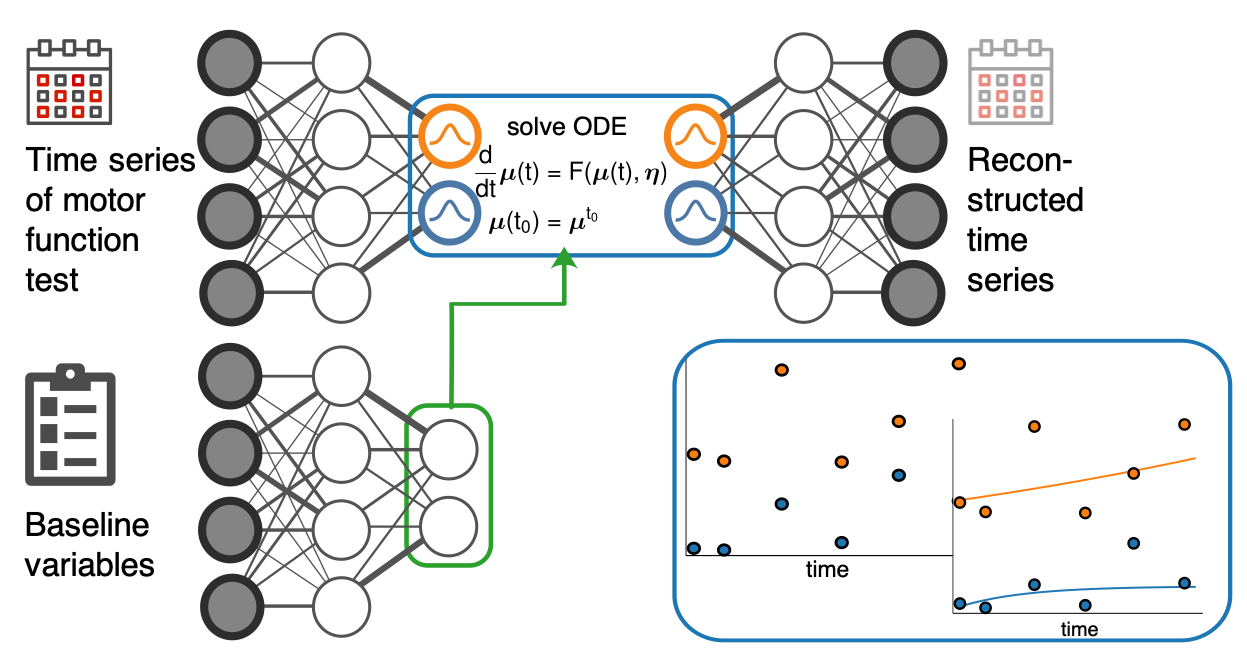

Again, we define a `struct` to represent our self-defined ODE-VAE type, and tell Julia how to create such an object. 

In [ ]:
mutable struct ODE_VAE 
    encoder
    encodedμ 
    encodedlogσ 
    decoder
    decodedμ 
    decodedlogσ 
    paramNN
    ODEprob
end

# initialize model
function ODE_VAE(p::Int, q::Int, zdim::Int, nODEparams::Int, ODEprob; seed::Int=1234)
    myinit = Flux.glorot_uniform
    shift(arg) = sigmoid(arg).-0.5
    # seed
    Random.seed!(seed)
    # parameter network
    paramNN = Chain(Dense(q,q,tanh, init=myinit), 
                Dense(q, nODEparams, arg ->(shift(arg)), init=myinit), 
                Flux.Diagonal(nODEparams))
    #   VAE encoder
    Dz, Dh = zdim, p
    encoder, encodedμ, encodedlogσ = Dense(p, Dh, arg ->(tanh.(arg) .+ 1)), Dense(Dh, Dz), Chain(Dense(Dh, Dz, arg -> -relu(arg)), Flux.Diagonal(Dz))
    # VAE decoder
    decoder, decodedμ, decodedlogσ = Dense(Dz, Dh, tanh), Dense(Dh, p), Dense(Dh, p)
    return ODE_VAE(encoder, encodedμ, encodedlogσ, decoder, decodedμ, decodedlogσ, paramNN, ODEprob)
end

Next, we define the model loss: We augment the classical VAE loss given by the negative evidence lower bound (ELBO) by adding a term that enforces consistency of latent representation before solving the ODE (=obtained directly from putting the data from subsequent measurement time points through the VAE encoder) and after solving the ODE with the individual-specific parameters obtained from the ODE-net and the baseline variables. 

In [ ]:
function loss(m::ODE_VAE, X, Y, t)
    latentμ, latentlogσ = m.encodedμ(m.encoder(X)), m.encodedlogσ(m.encoder(X))
    learnedparams = m.paramNN(Y)
    curparams = [learnedparams[1], m.ODEprob.p[2], m.ODEprob.p[3], learnedparams[2]]
    curts = Int.(floor.(t .*(1 ./dt) .+1))
    smoothμ = Array(solve(m.ODEprob, Tsit5(), u0 = [latentμ[1,1], latentμ[2,1]], p=curparams, saveat=dt))[:,curts]
    combinedμ = hcat(latentμ[:,1],smoothμ)
    combinedz = latentz.(combinedμ, latentlogσ)
    ELBO = 1.0 .* logp_x_z(m, X, combinedz) .- 0.5 .* kl_q_p(combinedμ, latentlogσ)
    lossval = sum(-ELBO) + 0.01*reg(m) + 1.0*sum((smoothμ .- latentμ[:,2:end]).^2)
    return lossval
end

getparams(m::ODE_VAE) = Flux.params(m.encoder, m.encodedμ, m.encodedlogσ, m.decoder, m.decodedμ, m.decodedlogσ, m.paramNN) # get parameters of VAE model

Just as before, we can now train the model! We only need to gather together the training data, as it includes some more pieces than before (the time points, and the baseline variables). Also, we additionally want to look at the fitted ODE trajectories during model training, so let's also add a new plotting function for that. 

In [ ]:
"""
    eval_z_trajectories(xs, x_params,tvals, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false)

Callback function to be used during training: Plot the fitted latent space ODE solutions and the encoder values before solving the ODE
    for some exemplary individuals in the dataset, together with the ground truth underlying ODE trajectories.  

Inputs:
 - `xs`: vector of length `n` = n_individuals, where the `i`th element is a (n_vars=p x n_timepoints) matrix 
        containing the time-dependent variables of the `i`th individual in the dataset
 - `x_params`: vector of length `n` = n_individuals, where the `i`th  element is a vector of length (n_baselinevars=q)
        containing the baseline information for the `i`th individual in the dataset 
 - `tvals`: vector of length `n` = n_individuals, where the `i`th element is a vector of length 1 (or more generally n_timepoints_i)
        containing the time point of the `i`th individual's second measurement (or all the timepoints after the baseline visit)
 - `group1`: indices of all individuals in group1 - since [group1, group2] = {1,...,n}, the `group2` indices can be inferred from that 
 - `sol_group1`: true ODE solution of the first group 
 - `sol_group2`: true ODE solution of the second group 
 - `m`: ODE-VAE model of which the latent space should be exemplarily visualized 
 - `dt`: time interval in which to use the ODE, needed to ensure correct array dimensions for plotting 
 - `swapcolorcoding`: optional keyword argument whether or not to swap the orange - blue color coding for the true underlying trajectories, 
        as the VAE can arbitrarily flip / rotate the latent representation, sometimes resulting in inverted dimensions, 
        which can be visually remedied by swapping the color coding there. Default = `false`. 

Returns: 
    A plot with 4 panels representing the latent space of one individual each. The true underlying ODE solutions are shown as dashed curves
    and the fitted ones obtained from solving the individually parameterized ODE in the latent space are shown as solid curves. 
    The two latent space dimensions are color-coded in orange and blue. 
"""
function eval_z_trajectories(xs, x_params,tvals, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false) # look at trajectories of first 4 individuals during training
    plotarray=[]
    for ind in 2:5
        curgroup = ind ∈ group1 ? 1 : 2
        colors_truesol = swapcolorcoding ? ["#ff7f0e" "#1f77b4"] : ["#1f77b4" "#ff7f0e"]
        curxs = xs[ind]
        curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
        curz = latentz.(curmu, cursi)
        learnedparams = m.paramNN(x_params[ind])
        if length(m.paramNN.layers[end].scale) == 2
            curparams = Float32[learnedparams[1], m.ODEprob.p[2], m.ODEprob.p[3], learnedparams[2]]
        else
            curparams = learnedparams
        end    
        curts = tvals[ind] .* (1 ./dt) .+ 1
        origt1s = repeat([tvals[ind]], length(curxs[:,1]))
        cursol = solve(m.ODEprob, Tsit5(), u0 = curmu[:,1], p=curparams, saveat = dt)
        curplot = curgroup == 1 ? plot(sol_group1.t, sol_group1'; legend=false, line=([:dot :dot], 3, colors_truesol)) : plot(sol_group2.t, sol_group2'; legend=false, line=([:dot :dot], 3, colors_truesol))
        plot!(cursol.t, cursol'; line=(2, ["#1f77b4" "#ff7f0e"]))
        Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[1,:], marker = (:c, 4, "#1f77b4")) 
        Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[2,:], marker = (:c, 4, "#ff7f0e"))
        push!(plotarray, curplot)
    end
    myplot = plot(plotarray[:]..., layout=(2,2))
    return myplot
end

Now, let's initialise our model, gather the training data and look at the initial loss and latent space. 

In [ ]:
zdim = nODEparams = 2
m = ODE_VAE(p, q, zdim, nODEparams, prob1, seed=42);

In [ ]:
trainingdata = zip(xs, x_baseline, tvals)
@info "mean loss: $(mean(loss(m, d...) for d in trainingdata))"
display(eval_z_trajectories(xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, swapcolorcoding=true))

Time to start training!

In [ ]:
ps = getparams(m)
opt = ADAM(0.0005)

for epoch in 1:25
    for d in trainingdata 
        grads = Flux.gradient(()-> loss(m, d...), ps)
        Flux.Optimise.update!(opt, ps, grads)
    end
    if epoch % 5 == 0
        @info "mean loss: $(mean(loss(m, d...) for d in trainingdata))"
        display(eval_z_trajectories(xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, swapcolorcoding=true))
    end
end

We can now visualize what the model has learnt, by looking at the fitted trajectories in each of the two groups from each individual (thin solid lines in the plot) and compare them to the ground-truth solutions (dashed thicker lines). Additionally, we can visually evaluate how well the latent representations before and after solving the ODE match by comparing the dots (=latent representation means obtained directly from the encoder) with the solid lines (latent fitted ODE solutions). 

We first need to define plotting functions for that, again... 

In [ ]:
"""
    plot_individual_solutions(ind, xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false, showlegend::Bool=true)

Plot the fitted ODE solutions in the latent space of the ODE-VAE `m` and the encoded datapoints before solving the ODE together with 
    the ground-truth underlying ODE trajectory for one individual, defined by its index `ind`.

Inputs: 
 - `ind`: the index of the individual in the dataset, between 1 and `n` = n_individuals
 - `xs`: vector of length `n` = n_individuals, where the `i`th element is a (n_vars=p x n_timepoints) matrix 
        containing the time-dependent variables of the `i`th individual in the dataset
 - `x_baseline`: vector of length `n` = n_individuals, where the `i`th  element is a vector of length (n_baselinevars=q)
        containing the baseline information for the `i`th individual in the dataset 
 - `tvals`: vector of length `n` = n_individuals, where the `i`th element is a vector of length 1 (or more generally n_timepoints_i)
        containing the time point of the `i`th individual's second measurement (or all the timepoints after the baseline visit)
 - `group1`: indices of all individuals in group1 - since [group1, group2] = {1,...,n}, the `group2` indices can be inferred from that 
 - `sol_group1`: true ODE solution of the first group 
 - `sol_group2`: true ODE solution of the second group 
 - `m`: ODE-VAE model of which the latent space should be exemplarily visualized 
 - `dt`: time interval in which to use the ODE, needed to ensure correct array dimensions for plotting 
 - `swapcolorcoding`: optional keyword argument whether or not to swap the orange - blue color coding for the true underlying trajectories, 
        as the VAE can arbitrarily flip / rotate the latent representation, sometimes resulting in inverted dimensions, 
        which can be visually remedied by swapping the color coding there. Default = `false`
 - `showlegend`: optional keyword argument whether or not to display the plot legend. Default = `true`

Returns: 
    A plot representing the latent space of one individual. The true underlying ODE solutions are shown as dashed curves
    and the fitted one by solving the individually parameterized ODE in the latent space are shown as solid curves, 
    the encoded datapoints are scattered on top. The two latent space dimensions are color-coded in orange and blue. 
"""
function plot_individual_solutions(ind, xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt; swapcolorcoding::Bool=false, showlegend::Bool=true) # look at trajectories of one individual after training 
    curgroup = ind ∈ group1 ? 1 : 2
    colors_truesol = swapcolorcoding ? ["#ff7f0e" "#1f77b4"] : ["#1f77b4" "#ff7f0e"]
    if curgroup == 1
        sol = sol_group1
        legend = showlegend ? :topright : false
        truesollabels = ""
        smoothlabels = ""
        label1 = ""
        label2 = ""
    else
        sol = sol_group2
        legend = showlegend ? :topleft : false
        truesollabels = [L"\mathrm{true~}u_1" L"\mathrm{true~}u_2"]
        smoothlabels = [L"\mathrm{smooth~}\mu_1" L"\mathrm{smooth~}\mu_2"]
        label1 = L"\mu_1 \mathrm{~from~encoder}"
        label2 = L"\mu_2 \mathrm{~from~encoder}"
    end
    curxs = xs[ind]
    curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
    learnedparams = m.paramNN(x_baseline[ind])
    if length(m.paramNN.layers[end].scale) == 2
        curparams = Float32[learnedparams[1], m.ODEprob.p[2], m.ODEprob.p[3], learnedparams[2]]
    else
        curparams = learnedparams
    end    
    cursol = solve(m.ODEprob, Tsit5(), u0 = curmu[:,1], p=curparams, saveat = dt)
    curplot = plot(sol.t, sol'; labels=truesollabels, legend=legend, line=([:dot :dot], 3, colors_truesol))
    plot!(cursol.t, cursol'; labels=smoothlabels, line=(2, ["#1f77b4" "#ff7f0e"]))
    Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[1,:], label = label1, marker = (:c, 6, "#1f77b4")) 
    Plots.scatter!(cat(0,tvals[ind], dims=1), curmu[2,:], label = label2, marker = (:c, 6, "#ff7f0e"))
    plot!(xlab="time", ylab="value of latent representation")
    #display(curplot)

    return curplot

end

"""
    allindsplot(group, data::simdata, m, sol_group1, sol_group2; swapcolorcoding::Bool=false, showlegend::Bool=true)

Shows the fitted latent space ODE solutions and the encoded data points from all individuals in one group in one plot, 
    together with the true underlying ODE trajectory as dashed line. 

Inputs: 
 - `group`: integer specifying which group (1 or 2) to plot 
 - `data`: container of type `simdata` with all the simulated data (time-dependent and baseline variables, time points)
 - `m`: trained ODE-VAE model 
 - `sol_group1`: true ODE solution of the first group 
 - `sol_group2`: true ODE solution of the second group 
 - `swapcolorcoding`: optional keyword argument whether or not to swap the orange - blue color coding for the true underlying trajectories, 
        as the VAE can arbitrarily flip / rotate the latent representation, sometimes resulting in inverted dimensions, 
        which can be visually remedied by swapping the color coding there. Default = `false`
 - `showlegend`: optional keyword argument whether or not to display the plot legend. Default = `true`

Returns: 
    A plot showing all latent space ODE solutions and the encoded data points from all individuals in one group. 
    The true underlying ODE solutions are shown as dashed curves and the fitted one by solving the individually 
    parameterized ODE in the latent space are shown as solid curves, the encoded datapoints are scattered on top. 
    The two latent space dimensions are color-coded in orange and blue. 
"""
function allindsplot(group, data::simdata, m, sol_group1, sol_group2; swapcolorcoding::Bool=false, showlegend::Bool=true)
    # get data
    xs, x_params, tvals = data.xs, data.x_baseline, data.tvals
    # set parameters
    if group == 1
        sol = sol_group1
        groupinds = group1
        legendposition = showlegend ? :topright : false
        ylims = (-0.3,4.2)
    else
        sol = sol_group2
        groupinds = group2
        legendposition = showlegend ? :topleft : false
        ylims = (-0.5,12)
    end

    # plot true solution
    colors_truesol = swapcolorcoding ? ["#ff7f0e" "#1f77b4"] : ["#1f77b4" "#ff7f0e"]
    allindsplot1 = plot(sol.t, sol';
                    #ylims = ylims,
                    labels=[L"\mathrm{true~}u_1" L"\mathrm{true~}u_2"],
                    legend=legendposition,
                    line=([:dot :dot], 4, colors_truesol)#["#e6550d" "#3182bd"])
    )
    # get data from group currently looked at
    groupxs = xs[groupinds]
    groupx_params = x_params[groupinds]
    grouptvals = tvals[groupinds]
    # plot ODE solutions (= smooth latent μs as function of t)    
    for ind in 1:length(xs[groupinds])
        curxs = groupxs[ind]
        curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
        learnedparams = m.paramNN(groupx_params[ind])
        if length(m.paramNN.layers[end].scale) == 2
            curparams = Float32[learnedparams[1], m.ODEprob.p[2], m.ODEprob.p[3], learnedparams[2]]
        else
            curparams = learnedparams
        end
        cursol = solve(m.ODEprob, Tsit5(), u0 = curmu[:,1], p=curparams, saveat = dt)
        if ind == 2
            labels = [L"\mathrm{smooth~}\mu_1" L"\mathrm{smooth~}\mu_2"]
            label1 = L"\mu_1 \mathrm{~from~encoder}"
            label2 = L"\mu_2 \mathrm{~from~encoder}"
        else
            labels = ""
            label1 = ""
            label2 = ""
        end
        plot!(cursol.t, cursol'; label=labels, line=(0.5, ["#3182bd" "#e6550d"])) #["#6baed6" "#fd8d3c"]
    end
    # plot latent μs obtained directly from the encoder before the ODE solving step
    for ind in 1:length(xs[groupinds])
        curxs = groupxs[ind]
        curmu, cursi = m.encodedμ(m.encoder(curxs)), m.encodedlogσ(m.encoder(curxs))
        if ind == 2
            labels = [L"\mathrm{smooth~}\mu_1" L"\mathrm{smooth~}\mu_2"]
            label1 = L"\mu_1 \mathrm{~from~encoder}"
            label2 = L"\mu_2 \mathrm{~from~encoder}"
        else
            labels = ""
            label1 = ""
            label2 = ""
        end
        Plots.scatter!(cat(0,grouptvals[ind], dims=1),curmu[1,:]; label=label1, marker=(:c,4,"#9ecae1"))
        Plots.scatter!(cat(0,grouptvals[ind], dims=1),curmu[2,:]; label=label2, marker=(:c,4,"#fdae6b"))
    end
    plot!(xlab="time", ylab="value of latent representation")

    return allindsplot1

end

Now, we first look at some exemplary individual solutions, one from each group (you can change the numbers to get different individuals). 

In [ ]:
p1 = plot_individual_solutions(20,xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, 
                                swapcolorcoding=true, showlegend=true)
p2 = plot_individual_solutions(28,xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt, 
                                swapcolorcoding=true, showlegend=false)
display(p1)
display(p2)

Next, we look at the solutions across the datasets and plot the solutions from all individuals in one group together: 

In [ ]:
# solutions across the entire dataset
data = simdata(xs, x_baseline, tvals, group1, group2);

p3 = allindsplot(2, data, m, sol_group1, sol_group2, swapcolorcoding=true)
p4 = allindsplot(1, data, m, sol_group1, sol_group2, swapcolorcoding=true, showlegend=false)

display(p3)
display(p4)

# Exercises 

## Exploring the behavior of the model 

__Model training:__
* change some training hyperparameter (number of training epochs, learning rate) and see how they affect the result!
* change the seed used for model initialisation (in the `VAE` function)! 

__Simulation:__
 * change the noise used for simulating the time-dependent variables! (you can check the documentation of the function by calling `?(function_name)`, e.g., `?(generate_xs)`)
 * change the number of time points per individual, or the number of individuals in the dataset!
 * change the noise used for simulating the baseline variables!
 * change the strategy used for simulating the baseline variables from "trueparams" to "groupsonly"!

## Exploring model variants 

* what happens if you change the definition of the ODE systems, e.g., the true sets of parameters for the two groups? 
* *(advanced)* can you adapt the model to learn 4 ODE parameters, instead of just 2? does it work? 


# Bonus: Walkthrough for using automatic differentiation to train a simple classifier neural network

Of course, you can also fit a simple supervised neural network in Julia. 

In [ ]:
using Flux
using Random

dense_sol = solve(ODEProblem(linear_2d_system, u0, tspan, true_p), Tsit5(), saveat=0.01)
sol_mat = Array(dense_sol)
# split into two components 
# add some random noise
n=100 # dataset size
groups = rand([1,2], n)
dataset = Float32.(cat([sol_mat[i,:] .+ randn(size(sol_mat[i,:])) for i in groups]..., dims=2)')

randindex = shuffle(1:n)
train_inds = randindex[1:Int(floor(n*0.8))]
test_inds = randindex[Int(floor(n*0.8))+1:end]

train_data = dataset[train_inds,:]
test_data = dataset[test_inds,:]

labels = Float32.(groups) .- 1.0f0
train_labels = labels[train_inds]
test_labels = labels[test_inds]

Random.seed!(42)
inputdim = size(train_data,2)
classifier = Chain(
                Dense(inputdim, 10, relu),
                Dense(10, 1)
)

NNloss(m, x, y) = Flux.logitbinarycrossentropy(vec(m(x)), y)

# get the current loss and gradients wrt the model parameters 
ps = Flux.params(classifier)
NNloss(classifier, train_data', train_labels)
grads = Flux.gradient(() -> NNloss(classifier, train_data', train_labels), ps)
grads.grads
length(ps)

# train the model 
η = 0.001
nepochs=100
opt = ADAM(η)
trainingdata = Flux.DataLoader((train_data', train_labels), batchsize=10, shuffle=true)

trainlosses = []
testlosses = []

for epoch in 1:nepochs
    for batch in trainingdata
        grads = Flux.gradient(() -> NNloss(classifier, batch...), ps)
        Flux.Optimise.update!(opt, ps, grads)
    end
    push!(trainlosses, NNloss(classifier, train_data', train_labels))
    push!(testlosses, NNloss(classifier, test_data', test_labels))
    
    if epoch % 10 == 0 # show loss only at 20 timepoints
        @info "epoch $(epoch): current train loss: $(NNloss(classifier, train_data', train_labels)), current test loss: $(NNloss(classifier, test_data', test_labels))"
    end    
end

p1 = plot(collect(1:nepochs), hcat(log.(10, trainlosses .+ 1), log.(10, testlosses .+1 )), title = "Loss", label=["train-loss" "test-loss"], xlabel="number of epoch", ylabel="log10(model loss)", legend=:topright)

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />